In [15]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
plt.rcParams['axes.facecolor'] = 'none'

from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier

import shap

## Create Model

In [432]:
modeling_df = pd.read_csv('ncaa_tournament_modeling_df.csv')
modeling_df.head()

,Season,Round,Team_1,Team_2,Win,Team_1_Score,Team_2_Score,Team_1_Seed,Team_2_Seed,G_1,...,3PAr_2,TS%_2,TRB%_2,AST%_2,STL%_2,BLK%_2,eFG%_2,TOV%_2,ORB%_2,FT/FGA_2
0,2010,1,Kentucky,ETSU,True,100,71,1,16,1.891180,...,-0.692021,-1.390662,-0.731382,-1.894681,0.865511,-0.198698,-1.283715,1.120650,0.080611,-0.074455
1,2010,1,Texas,Wake Forest,False,80,81,8,9,-0.374750,...,-2.060814,-1.617685,0.424742,-1.748915,-0.360031,0.738167,-1.528617,0.788290,1.071202,-0.154228
2,2010,1,Temple,Cornell,False,65,78,5,12,0.191733,...,1.903965,2.090359,0.147272,0.801995,0.281920,-0.098319,1.900006,0.068176,-0.440753,-1.776286
3,2010,1,Wisconsin,Wofford,True,53,49,4,13,-0.941232,...,-0.243623,-0.671756,0.054782,0.310034,0.048483,-1.570536,-0.653968,-0.264184,-0.284344,0.590323
4,2010,1,Marquette,Washington,False,78,80,6,11,-0.374750,...,-1.494417,-0.331221,0.193517,-0.692109,-0.301672,-0.098319,-0.583996,-0.651937,0.575907,0.563732


In [433]:
features = modeling_df.columns[7:]
features = [x for x in features if x not in ['G_1', 'W_1', 'L_1', 'G_2', 'W_2', 'L_2', 'Team_1_Seed', 'Team_2_Seed']]
target='Win'
modeling_df['Seed_Diff'] = modeling_df['Team_1_Seed'] - modeling_df['Team_2_Seed']

modeling_df['four_factors_1'] = modeling_df['eFG%_1'] + modeling_df['TOV_1'] - modeling_df['ORB_1'] + modeling_df['FT_1']
modeling_df['four_factors_2'] = modeling_df['eFG%_2'] + modeling_df['TOV_2'] - modeling_df['ORB_2'] + modeling_df['FT_2']
modeling_df['four_factors_diff'] = modeling_df['four_factors_1'] - modeling_df['four_factors_2']
modeling_df['four_factors_diff_scaled'] = StandardScaler().fit_transform(modeling_df[['four_factors_diff']])

modeling_df['net_efg'] = modeling_df['eFG%_1'] - modeling_df['eFG%_2']
modeling_df['net_efg_scaled'] = StandardScaler().fit_transform(modeling_df[['net_efg']])

modeling_df['net_pace'] = modeling_df['Pace_1'] - modeling_df['Pace_2']
modeling_df['net_pace_scaled'] = StandardScaler().fit_transform(modeling_df[['net_pace']])

# Calculate total wins for each school
team1_wins = modeling_df.groupby('Team_1')['Win'].sum().reset_index()
team1_wins.columns = ['School', 'Wins_as_Team1']

team2_wins = (modeling_df.groupby('Team_2')['Win'].count()-modeling_df.groupby('Team_2')['Win'].sum()).reset_index()
team2_wins.columns = ['School', 'Wins_as_Team2'] 

# Combine wins as Team 1 and Team 2
total_wins = pd.merge(team1_wins, team2_wins, on='School', how='outer').fillna(0)
total_wins['Total_Tournament_Wins'] = total_wins['Wins_as_Team1'] + total_wins['Wins_as_Team2']

# Add total wins back to main dataframe
modeling_df = pd.merge(modeling_df, total_wins[['School', 'Total_Tournament_Wins', 'Wins_as_Team1', 'Wins_as_Team2']], 
                      left_on='Team_1', right_on='School', how='left')
modeling_df = modeling_df.drop('School', axis=1)
modeling_df = pd.merge(modeling_df, total_wins[['School', 'Total_Tournament_Wins', 'Wins_as_Team1', 'Wins_as_Team2']], 
                      left_on='Team_2', right_on='School', how='left',
                      suffixes=('_1', '_2'))
modeling_df = modeling_df.drop('School', axis=1)

modeling_df['Total_Tournament_Wins_1'] = modeling_df['Total_Tournament_Wins_1'].fillna(0)
modeling_df['Total_Tournament_Wins_2'] = modeling_df['Total_Tournament_Wins_2'].fillna(0)

modeling_df['Total_Tournament_Wins_diff'] = modeling_df['Total_Tournament_Wins_1'] - modeling_df['Total_Tournament_Wins_2']
modeling_df['Total_Tournament_Wins_diff_scaled'] = StandardScaler().fit_transform(modeling_df[['Total_Tournament_Wins_diff']])

# Create a dataframe with wins by team and season
team_season_wins = pd.DataFrame()

# Get wins for each team in each season as Team_1
team1_season_wins = modeling_df.groupby(['Season', 'Team_1'])['Win'].sum().reset_index()
team1_season_wins.columns = ['Season', 'School', 'Wins']

# Get wins for each team in each season as Team_2
team2_season_wins = modeling_df.groupby(['Season', 'Team_2'])['Win'].apply(lambda x: len(x) - sum(x)).reset_index()
team2_season_wins.columns = ['Season', 'School', 'Wins']

# Combine the two dataframes
team_season_wins = pd.concat([team1_season_wins, team2_season_wins])
team_season_wins = team_season_wins.groupby(['Season', 'School'])['Wins'].sum().reset_index()

# Calculate 3-year rolling sum of tournament wins
def calculate_rolling_tournament_wins(df):
    # Sort by Season
    df = df.sort_values('Season')
    
    # For each season, calculate the sum of wins in the previous 3 seasons (including current)
    rolling_wins = []
    for i, row in df.iterrows():
        current_season = row['Season']
        # Get seasons to include (current and 2 previous)
        seasons_to_include = [current_season, current_season-1, current_season-2]
        # Filter for those seasons
        prev_seasons = df[df['Season'].isin(seasons_to_include)]
        # Sum the wins
        total_wins = prev_seasons['Wins'].sum()
        rolling_wins.append(total_wins)
    
    return rolling_wins

# Apply the function to each school group
team_season_wins['Rolling_3yr_Tournament_Wins'] = team_season_wins.groupby('School').apply(
    lambda x: pd.Series(calculate_rolling_tournament_wins(x))
).reset_index(drop=True)

# Merge the rolling wins back to the main dataframe
modeling_df = pd.merge(modeling_df, 
                      team_season_wins[['Season', 'School', 'Rolling_3yr_Tournament_Wins']], 
                      left_on=['Season', 'Team_1'], 
                      right_on=['Season', 'School'], 
                      how='left')
modeling_df = modeling_df.drop('School', axis=1)

modeling_df = pd.merge(modeling_df, 
                      team_season_wins[['Season', 'School', 'Rolling_3yr_Tournament_Wins']], 
                      left_on=['Season', 'Team_2'], 
                      right_on=['Season', 'School'], 
                      how='left',
                      suffixes=('_1', '_2'))
modeling_df = modeling_df.drop('School', axis=1)

modeling_df['Rolling_3yr_Tournament_Wins_1'] = modeling_df['Rolling_3yr_Tournament_Wins_1'].fillna(0)
modeling_df['Rolling_3yr_Tournament_Wins_2'] = modeling_df['Rolling_3yr_Tournament_Wins_2'].fillna(0)

modeling_df['Rolling_3yr_Tournament_Wins_diff'] = modeling_df['Rolling_3yr_Tournament_Wins_1'] - modeling_df['Rolling_3yr_Tournament_Wins_2']
modeling_df['Rolling_3yr_Tournament_Wins_diff_scaled'] = StandardScaler().fit_transform(modeling_df[['Rolling_3yr_Tournament_Wins_diff']])

# Find max round for each team
team1_max_round = modeling_df.groupby('Team_1')['Round'].max().reset_index()
team1_max_round.columns = ['School', 'Max_Round_as_Team1']

team2_max_round = modeling_df.groupby('Team_2')['Round'].max().reset_index() 
team2_max_round.columns = ['School', 'Max_Round_as_Team2']

# Combine max rounds as Team 1 and Team 2
max_rounds = pd.merge(team1_max_round, team2_max_round, on='School', how='outer').fillna(0)
max_rounds['Max_Tournament_Round'] = max_rounds[['Max_Round_as_Team1', 'Max_Round_as_Team2']].max(axis=1)

# Add max round back to main dataframe
modeling_df = pd.merge(modeling_df, max_rounds[['School', 'Max_Tournament_Round']], 
                      left_on='Team_1', right_on='School', how='left')
modeling_df = modeling_df.drop('School', axis=1)
modeling_df = pd.merge(modeling_df, max_rounds[['School', 'Max_Tournament_Round']], 
                      left_on='Team_2', right_on='School', how='left',
                      suffixes=('_1', '_2'))
modeling_df = modeling_df.drop('School', axis=1)

modeling_df['Max_Tournament_Round_1'] = modeling_df['Max_Tournament_Round_1'].fillna(0)
modeling_df['Max_Tournament_Round_2'] = modeling_df['Max_Tournament_Round_2'].fillna(0)

modeling_df['Max_Tournament_Round_diff'] = modeling_df['Max_Tournament_Round_1'] - modeling_df['Max_Tournament_Round_2']
modeling_df['Max_Tournament_Round_diff_scaled'] = StandardScaler().fit_transform(modeling_df[['Max_Tournament_Round_diff']])

# Create a dataframe with max round by team and season
team_season_rounds = pd.DataFrame()

# Get max round for each team in each season as Team_1
team1_season_rounds = modeling_df.groupby(['Season', 'Team_1'])['Round'].max().reset_index()
team1_season_rounds.columns = ['Season', 'School', 'Max_Round']

# Get max round for each team in each season as Team_2
team2_season_rounds = modeling_df.groupby(['Season', 'Team_2'])['Round'].max().reset_index()
team2_season_rounds.columns = ['Season', 'School', 'Max_Round']

# Combine the two dataframes
team_season_rounds = pd.concat([team1_season_rounds, team2_season_rounds])
team_season_rounds = team_season_rounds.groupby(['Season', 'School'])['Max_Round'].max().reset_index()

# Create a function to calculate rolling max round for each team and season
def calculate_rolling_max_round(school, season, df):
    # Get seasons to include (current and 2 previous)
    seasons_to_include = [season-1, season-2, season-3]
    # Filter for these seasons
    prev_rounds = df[(df['School'] == school) & (df['Season'].isin(seasons_to_include))]['Max_Round']
    # Calculate max round
    if len(prev_rounds) > 0:
        return prev_rounds.max()
    else:
        return 0

# Create empty dataframe to store results
rolling_max_rounds = []

# Calculate rolling max round for each team and season
for school in team_season_rounds['School'].unique():
    school_data = team_season_rounds[team_season_rounds['School'] == school]
    for _, row in school_data.iterrows():
        rolling_max_rounds.append({
            'School': school,
            'Season': row['Season'],
            'Rolling_Max_Round': calculate_rolling_max_round(school, row['Season'], team_season_rounds)
        })

# Convert to DataFrame
rolling_max_rounds = pd.DataFrame(rolling_max_rounds)

# Merge rolling max rounds back to the main dataframe
modeling_df = pd.merge(
    modeling_df, 
    rolling_max_rounds,
    left_on=['Season', 'Team_1'],
    right_on=['Season', 'School'],
    how='left'
)
modeling_df = modeling_df.drop('School', axis=1)
modeling_df.rename(columns={'Rolling_Max_Round': 'Max_Tournament_Round_1_rolling'}, inplace=True)

modeling_df = pd.merge(
    modeling_df, 
    rolling_max_rounds,
    left_on=['Season', 'Team_2'],
    right_on=['Season', 'School'],
    how='left'
)
modeling_df = modeling_df.drop('School', axis=1)
modeling_df.rename(columns={'Rolling_Max_Round': 'Max_Tournament_Round_2_rolling'}, inplace=True)

# Fill NaN values with 0
modeling_df['Max_Tournament_Round_1_rolling'] = modeling_df['Max_Tournament_Round_1_rolling'].fillna(0)
modeling_df['Max_Tournament_Round_2_rolling'] = modeling_df['Max_Tournament_Round_2_rolling'].fillna(0)

# Calculate difference and scale
modeling_df['Max_Tournament_Round_diff_rolling'] = modeling_df['Max_Tournament_Round_1_rolling'] - modeling_df['Max_Tournament_Round_2_rolling']
modeling_df['Max_Tournament_Round_diff_scaled_rolling'] = StandardScaler().fit_transform(modeling_df[['Max_Tournament_Round_diff_rolling']])


modeling_df

,Season,Round,Team_1,Team_2,Win,Team_1_Score,Team_2_Score,Team_1_Seed,Team_2_Seed,G_1,...,Rolling_3yr_Tournament_Wins_diff,Rolling_3yr_Tournament_Wins_diff_scaled,Max_Tournament_Round_1,Max_Tournament_Round_2,Max_Tournament_Round_diff,Max_Tournament_Round_diff_scaled,Max_Tournament_Round_1_rolling,Max_Tournament_Round_2_rolling,Max_Tournament_Round_diff_rolling,Max_Tournament_Round_diff_scaled_rolling
0,2010,1,Kentucky,ETSU,True,100,71,1,16,1.891180,...,6.0,1.605775,6.0,1.0,5.0,1.521050,0.0,0.0,0.0,-0.602718
1,2010,1,Texas,Wake Forest,False,80,81,8,9,-0.374750,...,2.0,0.479254,4.0,2.0,2.0,0.161248,0.0,0.0,0.0,-0.602718
2,2010,1,Temple,Cornell,False,65,78,5,12,0.191733,...,5.0,1.324145,2.0,3.0,-1.0,-1.198554,0.0,0.0,0.0,-0.602718
3,2010,1,Wisconsin,Wofford,True,53,49,4,13,-0.941232,...,0.0,-0.084007,6.0,2.0,4.0,1.067783,0.0,0.0,0.0,-0.602718
4,2010,1,Marquette,Washington,False,78,80,6,11,-0.374750,...,5.0,1.324145,4.0,3.0,1.0,-0.292019,0.0,0.0,0.0,-0.602718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,2024,3,Marquette,NC State,False,58,67,2,11,1.083212,...,7.0,1.887406,4.0,5.0,-1.0,-1.198554,2.0,1.0,1.0,-0.175118
814,2024,4,Duke,NC State,False,64,76,4,11,0.437085,...,0.0,-0.084007,6.0,5.0,1.0,-0.292019,5.0,1.0,4.0,1.107684
815,2024,5,UConn,Alabama,True,86,72,1,4,3.021591,...,-4.0,-1.210529,6.0,5.0,1.0,-0.292019,5.0,3.0,2.0,0.252483
816,2024,5,Purdue,NC State,True,63,50,1,11,2.375464,...,9.0,2.450667,6.0,5.0,1.0,-0.292019,3.0,1.0,2.0,0.252483


In [434]:
rolling_max_rounds

,School,Season,Rolling_Max_Round
0,BYU,2010,0
1,BYU,2012,2
2,BYU,2014,1
3,BYU,2021,0
4,BYU,2024,1
...,...,...,...
830,State UAB,2024,0
831,State Yale,2024,0
832,Stetson,2024,0
833,Wagner,2024,0


In [435]:
def calculate_game_weight(row):
    round_weights = {
    1: 1.0,      # First Round (Round of 64)
    2: 1.5,      # Second Round (Round of 32)
    3: 2.0,      # Sweet 16
    4: 3.0,      # Elite 8
    5: 4.0,      # Final Four
    6: 5.0       # Championship
    }
    
    # Get round weight
    round_weight = round_weights[row['Round']]
    
    # Calculate upset weight
    if row['Win'] == 1:  # If Team_1 won
        upset_weight = calculate_upset_weight(row['Team_1_Seed'], row['Team_2_Seed'])
    else:  # If Team_2 won
        upset_weight = calculate_upset_weight(row['Team_2_Seed'], row['Team_1_Seed'])
    
    # Combine weights multiplicatively
    combined_weight = .5*round_weight + .5*upset_weight
    
    return combined_weight

def calculate_upset_weight(team1_seed, team2_seed):
    # Assuming team1 is the winner
    seed_diff = team1_seed - team2_seed
    
    if seed_diff > 0:  # If higher seed (underdog) beats lower seed
        # Exponential weighting for bigger upsets
        return 1.0 + (seed_diff ** 1.5) / 10
    else:
        return 1.0  # No upset bonus for favorite winning

Selected Features:
Max_Tournament_Round_diff            0.067474
W-L%_1                               0.045294
3P_1                                 0.019895
Rolling_3yr_Tournament_Wins_1        0.014047
ORtg_1                               0.007434
Wins_as_Team1_2                      0.004471
Wins_as_Team1_1                      0.001977
Wins_as_Team2_1                     -0.002889
Seed_Diff                           -0.006260
Max_Tournament_Round_diff_rolling   -0.020674
Wins_as_Team2_2                     -0.034006
dtype: float64


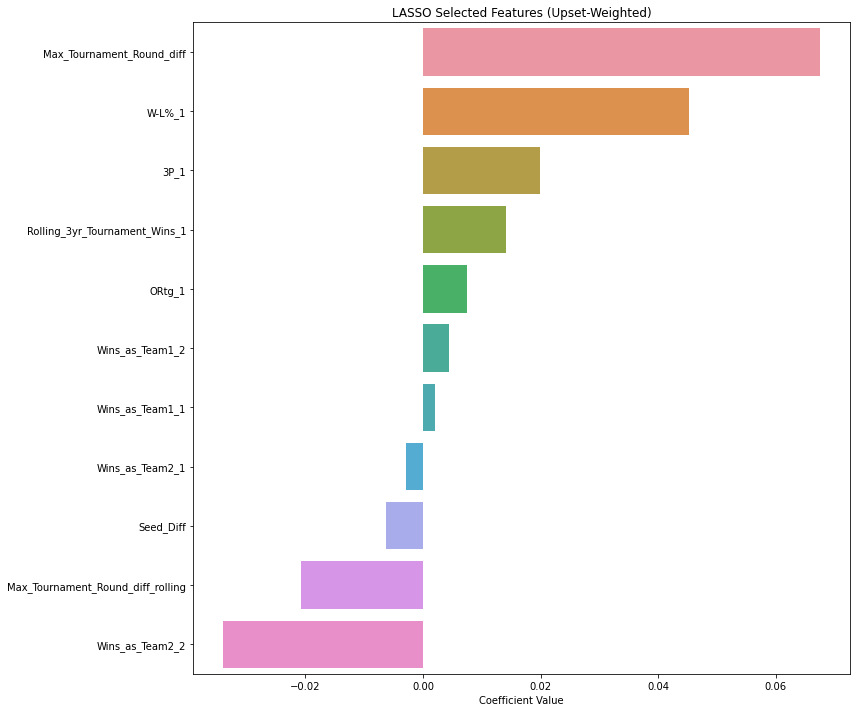


Upset Prediction Performance:
Overall Accuracy: 0.7638888888888888
Upset Accuracy: 0.6875
Non-Upset Accuracy: 0.7857142857142857

Classification Report:
              precision    recall  f1-score   support

       False       0.64      0.81      0.71        26
        True       0.87      0.74      0.80        46

    accuracy                           0.76        72
   macro avg       0.75      0.77      0.76        72
weighted avg       0.79      0.76      0.77        72



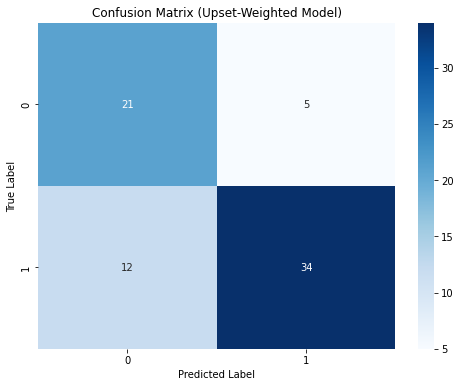


Feature Importance for Upset Prediction:
                              Feature  Coefficient  Abs_Importance
9           Max_Tournament_Round_diff     0.067474        0.067474
0                              W-L%_1     0.045294        0.045294
7                     Wins_as_Team2_2    -0.034006        0.034006
10  Max_Tournament_Round_diff_rolling    -0.020674        0.020674
1                                3P_1     0.019895        0.019895
8       Rolling_3yr_Tournament_Wins_1     0.014047        0.014047
2                              ORtg_1     0.007434        0.007434
3                           Seed_Diff    -0.006260        0.006260
6                     Wins_as_Team1_2     0.004471        0.004471
5                     Wins_as_Team2_1    -0.002889        0.002889
4                     Wins_as_Team1_1     0.001977        0.001977

Feature Correlations with Upsets:
                              Feature  Correlation_with_Upsets
86                    Wins_as_Team2_2                 0.

In [436]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns

# Load your data
#modeling_df = pd.read_csv('ncaa_tournament_modeling_df.csv').dropna().reset_index(drop=True)
#modeling_df=modeling_df.loc[modeling_df['Season']>2017].reset_index(drop=True).copy()

# Create an upset indicator (when lower seed beats higher seed)
modeling_df['is_upset'] = ((modeling_df['Team_1_Seed'] < modeling_df['Team_2_Seed']-2) & (modeling_df['Win'] == 0)) | \
                         ((modeling_df['Team_1_Seed']-2 > modeling_df['Team_2_Seed']) & (modeling_df['Win'] == 1))

modeling_df['Seed_Diff'] = modeling_df['Team_1_Seed'] - modeling_df['Team_2_Seed']

modeling_df['four_factors_1'] = modeling_df['eFG%_1'] + modeling_df['TOV_1'] - modeling_df['ORB_1'] + modeling_df['FT_1']
modeling_df['four_factors_2'] = modeling_df['eFG%_2'] + modeling_df['TOV_2'] - modeling_df['ORB_2'] + modeling_df['FT_2']
modeling_df['four_factors_diff'] = modeling_df['four_factors_1'] - modeling_df['four_factors_2']
modeling_df['four_factors_diff_scaled'] = StandardScaler().fit_transform(modeling_df[['four_factors_diff']])

modeling_df['net_efg'] = modeling_df['eFG%_1'] - modeling_df['eFG%_2']
modeling_df['net_efg_scaled'] = StandardScaler().fit_transform(modeling_df[['net_efg']])

features = modeling_df.columns[7:]
features = [x for x in features if x not in ['G_1', 'W_1', 'L_1', 'G_2', 'W_2', 'L_2', 'Team_1_Seed', 'Team_2_Seed', 'is_upset']]

# Create sample weights (give more importance to upsets)
sample_weights = np.ones(len(modeling_df))
# Weight later rounds more heavily
# Add the weights as new columns
round_weights = {
    1: 1.0,      # First Round (Round of 64)
    2: 1.5,      # Second Round (Round of 32)
    3: 2.0,      # Sweet 16
    4: 3.0,      # Elite 8
    5: 4.0,      # Final Four
    6: 5.0       # Championship
    }
modeling_df['round_weight'] = modeling_df['Round'].map(round_weights)
modeling_df['upset_weight'] = modeling_df.apply(lambda row: calculate_upset_weight(
    row['Team_1_Seed'] if row['Win'] == 1 else row['Team_2_Seed'],
    row['Team_2_Seed'] if row['Win'] == 1 else row['Team_1_Seed']
), axis=1)
modeling_df['combined_weight'] = modeling_df['round_weight'] #Adjust this weight to emphasize upsets more or less

holdout_df = modeling_df.loc[modeling_df['Season']<=2017].dropna().reset_index(drop=True).copy()
modeling_df = modeling_df.loc[modeling_df['Season']>2017].dropna().reset_index(drop=True).copy()

# Separate features and target
X = modeling_df[features]
y = modeling_df['Win']
sample_weights = modeling_df['combined_weight']

# Split the data while preserving upset ratio
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(
    X, y, sample_weights, test_size=0.2, random_state=42, stratify=modeling_df['is_upset']
)

# Create custom scorer that rewards upset predictions
from sklearn.metrics import make_scorer
def upset_weighted_score(y_true, y_pred, sample_weight=None):
    correct = y_true == y_pred
    # Create upset mask based on original data
    upset_mask = modeling_df['is_upset'].values[y_test.index]
    # Give more weight to correctly predicted upsets
    scores = np.where(upset_mask, 2.0, 1.0) * correct
    return np.average(scores, weights=sample_weight)

upset_scorer = make_scorer(upset_weighted_score)

# Perform LASSO with cross-validation using custom scorer and sample weights
lasso_cv = LassoCV(cv=5, random_state=42, max_iter=100000, 
                   alphas=np.logspace(-4, 0, 100))
lasso_cv.fit(X_train, y_train, sample_weight=weights_train)

# Get feature coefficients
feature_names = X.columns
coef = pd.Series(lasso_cv.coef_, index=feature_names)

# Print non-zero coefficients (selected features)
print("Selected Features:")
selected_features = coef[coef != 0].sort_values(ascending=False)
print(selected_features)

# Visualize feature importance
plt.figure(figsize=(12, 10))
sns.barplot(x=selected_features.values, y=selected_features.index)
plt.title('LASSO Selected Features (Upset-Weighted)')
plt.xlabel('Coefficient Value')
plt.tight_layout()
plt.show()

# Evaluate model performance with focus on upsets
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

# Train logistic regression with selected features
selected_features = coef[coef != 0]
X_train_selected = X_train[selected_features.index.values]
X_test_selected = X_test[selected_features.index.values]

lr = LogisticRegression(random_state=42, class_weight='balanced')
lr.fit(X_train_selected, y_train, sample_weight=weights_train)

# Make predictions
y_pred = lr.predict(X_test_selected)

# Analyze upset prediction performance
test_upsets = modeling_df['is_upset'].values[y_test.index]
print("\nUpset Prediction Performance:")
print("Overall Accuracy:", (y_test == y_pred).mean())
print("Upset Accuracy:", (y_test[test_upsets] == y_pred[test_upsets]).mean())
print("Non-Upset Accuracy:", (y_test[~test_upsets] == y_pred[~test_upsets]).mean())

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Create confusion matrix with upset labels
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Upset-Weighted Model)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Calculate and display feature importance for upset prediction
upset_importance = pd.DataFrame({
    'Feature': selected_features.index,
    'Coefficient': selected_features.values,
    'Abs_Importance': np.abs(selected_features.values)
}).sort_values('Abs_Importance', ascending=False)

print("\nFeature Importance for Upset Prediction:")
print(upset_importance)

# Additional analysis: Feature correlation with upsets
upset_correlations = pd.DataFrame()
for feature in X.columns:
    correlation = np.corrcoef(X[feature], modeling_df['is_upset'])[0,1]
    upset_correlations = upset_correlations.append({
        'Feature': feature,
        'Correlation_with_Upsets': correlation
    }, ignore_index=True)

print("\nFeature Correlations with Upsets:")
print(upset_correlations.sort_values('Correlation_with_Upsets', ascending=False))

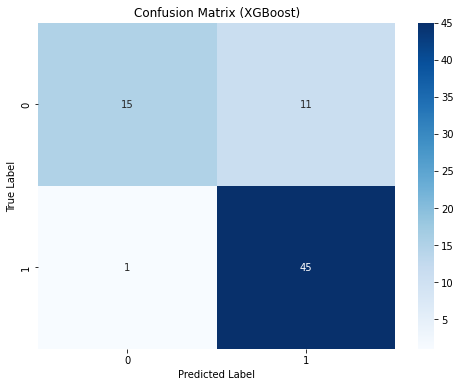

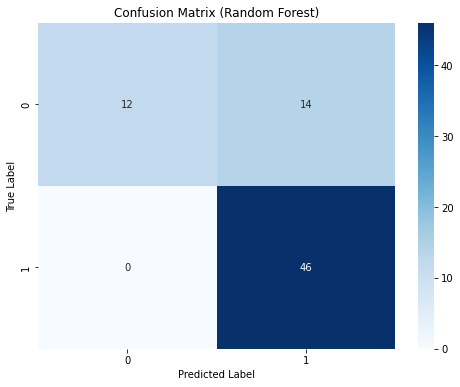

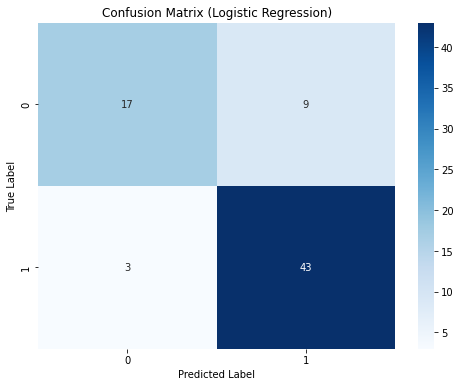

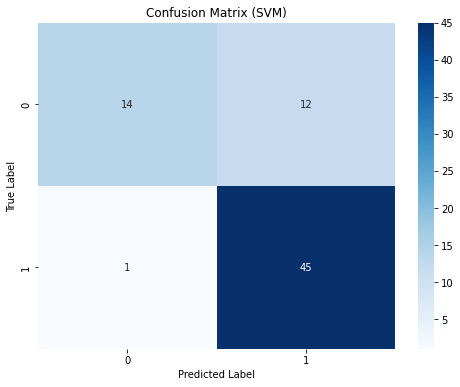

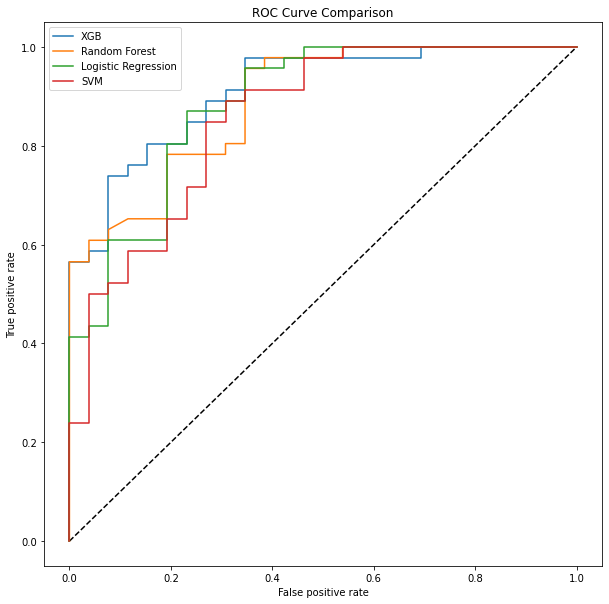

In [437]:
from sklearn.svm import SVC
features = selected_features.index.tolist()

# x_train = modeling_df[(modeling_df['Team_1_Score']+modeling_df['Team_2_Score']) % 10 < 7].dropna()
# y_train = x_train[target]

# x_test = modeling_df[(modeling_df['Team_1_Score']+modeling_df['Team_2_Score']) % 10 >= 7].dropna()
# y_test = x_test[target]

# Split the data while preserving upset ratio
x_train, x_test, y_train, y_test, weights_train, weights_test = train_test_split(
    modeling_df[features], modeling_df['Win'], sample_weights, test_size=0.2, random_state=42, stratify=modeling_df['is_upset']
)

XGB = XGBClassifier(use_label_encoder=False,random_state = 0, n_jobs=4, max_depth=2, n_estimators=20, gamma=3, min_child_weight=5, colsample_bytree = .5, subsample=.8, eval_metric='map')
#XGB = RandomForestClassifier(random_state=0, max_depth=3, n_estimators=30, n_jobs=-1, bootstrap=True, max_features=.8)
XGB.fit(x_train[features], y_train, sample_weight=weights_train)
fpr_xgb, tpr_xgb, thresholds_xgb = metrics.roc_curve(y_test, XGB.predict_proba(x_test[features])[:,1], drop_intermediate=True)

# Calculate and display confusion matrix for XGB
y_pred_xgb = XGB.predict(x_test[features])
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (XGBoost)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


# Create and train Random Forest model
RF = RandomForestClassifier(random_state=0, max_depth=3, n_estimators=30, n_jobs=4, max_features=0.8, bootstrap=True)
RF.fit(x_train[features], y_train, sample_weight=weights_train)

# Get ROC curve metrics for Random Forest
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(y_test, RF.predict_proba(x_test[features])[:,1], drop_intermediate=True)

# Calculate and display confusion matrix for RF
y_pred_rf = RF.predict(x_test[features])
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Random Forest)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Create and train Logistic Regression model
LR = LogisticRegression(random_state=0, max_iter=1000)
LR.fit(x_train[features], y_train, sample_weight=weights_train)

# Get ROC curve metrics for Logistic Regression
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(y_test, LR.predict_proba(x_test[features])[:,1], drop_intermediate=True)

# Calculate and display confusion matrix for LR
y_pred_lr = LR.predict(x_test[features])
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Logistic Regression)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



# Create and train SVM model
SVM = SVC(probability=True, random_state=0)
SVM.fit(x_train[features], y_train, sample_weight=weights_train)

# Get ROC curve metrics for SVM
fpr_svm, tpr_svm, thresholds_svm = metrics.roc_curve(y_test, SVM.predict_proba(x_test[features])[:,1], drop_intermediate=True)

# Calculate and display confusion matrix for SVM
y_pred_svm = SVM.predict(x_test[features])
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (SVM)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Update ROC plot to include SVM
plt.figure(figsize=(10,10))
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr_xgb, tpr_xgb, label='XGB')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')
plt.plot(fpr_svm, tpr_svm, label='SVM')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.title('ROC Curve Comparison')
plt.show()



In [438]:
# params = {
#         'gamma':[0, 1, 2, 3, 4, 5],
#         'n_estimators':[5, 10, 15, 20],
#         'min_child_weight':[5,10,15,20],
#         'max_depth':[2,3,4]
#         }

# grid = GridSearchCV(estimator=XGB, param_grid=params, n_jobs=-1)

# grid.fit(x_train[features], y_train)

# XGB = grid.best_estimator_

# print(f'Best estimator: {grid.best_estimator_}')
# print(f'\n Best score: {grid.best_score_**.5}')
# print(f'\n Best parameters: {grid.best_params_}')

In [439]:
from sklearn.ensemble import VotingClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

class FavoriteModel(BaseEstimator, ClassifierMixin):
    def fit(self, X, y=None):
        return self  # No fitting necessary

    def predict(self, X):
        return np.ones(X.shape[0], dtype=int)  # Always predict 1

    def predict_proba(self, X):
        return np.array([[0, 1]] * X.shape[0])  # Always predict probability of 1

favorite_model = FavoriteModel()


from sklearn.base import BaseEstimator, ClassifierMixin

class WeightedPredictionClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, weights=[0.6, 0.14, 0.14]):
        self.weights = weights

    def fit(self, X, y, XGB_model, LR_model, RF_model):
        self.XGB_model = XGB_model.fit(X, y)
        self.LR_model = LR_model.fit(X, y)
        self.RF_model = RF_model.fit(X, y)
        return self

    def predict_proba(self, X):
        lr_pred = self.LR_model.predict_proba(X)[:,1]
        rf_pred = self.RF_model.predict_proba(X)[:,1]
        xgb_pred = self.XGB_model.predict_proba(X)[:,1]
        
        # Calculate weighted probabilities for class 1
        weighted_prob_1 = (lr_pred * self.weights[1] + 
                          rf_pred * self.weights[2] + 
                          xgb_pred * self.weights[0])
        
        # Create a 2D array with shape (n_samples, 2) where each row is [prob_class_0, prob_class_1]
        result = np.zeros((X.shape[0], 2))
        result[:, 0] = 1 - weighted_prob_1  # Probability for class 0
        result[:, 1] = weighted_prob_1      # Probability for class 1
        
        return result
                
    def predict(self, X):
        weighted_preds = self.predict_proba(X)[:,1]  
        return (weighted_preds > 0.5).astype(int)  # Return 1 if weighted_preds > 0.5, else 0

In [440]:
features

['W-L%_1',
 '3P_1',
 'ORtg_1',
 'Seed_Diff',
 'Wins_as_Team1_1',
 'Wins_as_Team2_1',
 'Wins_as_Team1_2',
 'Wins_as_Team2_2',
 'Rolling_3yr_Tournament_Wins_1',
 'Max_Tournament_Round_diff',
 'Max_Tournament_Round_diff_rolling']

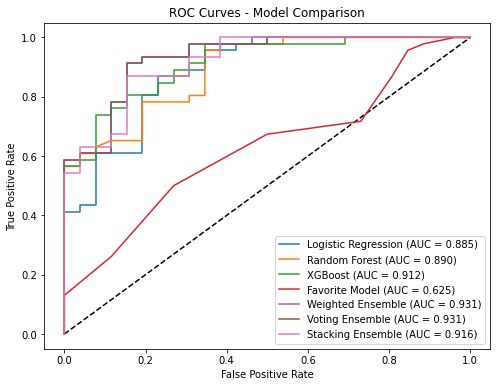

In [441]:
favorite_model=LogisticRegression().fit(pd.DataFrame(x_train['Max_Tournament_Round_diff_rolling']), y_train)

# Get probabilities from each model
lr_probs = LR.predict_proba(x_test[features])[:,1]
rf_probs = RF.predict_proba(x_test[features])[:,1] 
xgb_probs = XGB.predict_proba(x_test[features])[:,1]
favorite_probs = favorite_model.predict_proba(pd.DataFrame(x_test['Max_Tournament_Round_diff_rolling']))[:,1]

# Calculate ROC curves and AUC scores for individual models
fpr_lr, tpr_lr, _ = metrics.roc_curve(y_test, lr_probs)
auc_lr = metrics.auc(fpr_lr, tpr_lr)

fpr_rf, tpr_rf, _ = metrics.roc_curve(y_test, rf_probs) 
auc_rf = metrics.auc(fpr_rf, tpr_rf)

fpr_xgb, tpr_xgb, _ = metrics.roc_curve(y_test, xgb_probs)
auc_xgb = metrics.auc(fpr_xgb, tpr_xgb)

fpr_favorite, tpr_favorite, _ = metrics.roc_curve(y_test, favorite_probs)
auc_favorite = metrics.auc(fpr_favorite, tpr_favorite)

auc_total = auc_xgb+auc_lr+auc_rf
auc_weight_xgb = auc_xgb / auc_total
auc_weight_lr = auc_lr / auc_total
auc_weight_rf = auc_rf / auc_total

# Define the base models
base_models = [
    ('lr', LR),
    ('rf', RF),
    ('xgb', XGB),
    ('svm', SVM),
    ('favorite', favorite_model)
]

voting_clf = VotingClassifier(
    estimators=[('lr', LR), ('rf', RF), ('xgb', XGB)],
    voting='soft',
    weights=[auc_weight_lr, auc_weight_rf, auc_weight_xgb]
)
voting_clf.fit(x_train[features], y_train)


# Create the stacking classifier with logistic regression as the meta-model
stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=MLPClassifier(hidden_layer_sizes=(10,10), max_iter=500, random_state=42),
    #final_estimator=XGBClassifier(use_label_encoder=False,random_state = 0, n_jobs=4, max_depth=2, n_estimators=20, gamma=3, min_child_weight=5, colsample_bytree = .5, subsample=.8, eval_metric='map'),
    cv=5
)

# Fit the stacking classifier
stacking_clf.fit(x_train[features], y_train)

# Get predictions from the stacking classifier
stacking_preds = stacking_clf.predict(x_test[features])
stacking_probs = stacking_clf.predict_proba(x_test[features])[:, 1]

# Calculate ROC curve for stacking classifier
fpr_stacking, tpr_stacking, auc_stacking = metrics.roc_curve(y_test, stacking_probs)
auc_stacking = metrics.auc(fpr_stacking, tpr_stacking)


# Calculate weighted probabilities
weighted_prediction = WeightedPredictionClassifier(weights=[auc_weight_xgb, auc_weight_lr, auc_weight_rf])
weighted_prediction.fit(x_train[features], y_train, XGB, LR, RF)
weighted_probs = weighted_prediction.predict_proba(x_test[features])[:,1]

# Calculate ROC curve for weighted predictions
fpr_weighted, tpr_weighted, thresholds_weighted = metrics.roc_curve(y_test, weighted_probs)
auc_weighted = metrics.auc(fpr_weighted, tpr_weighted)

# Get voting classifier probabilities
voting_probs = voting_clf.predict_proba(x_test[features])[:,1]

# Calculate ROC curve for voting classifier
fpr_voting, tpr_voting, _ = metrics.roc_curve(y_test, voting_probs)
auc_voting = metrics.auc(fpr_voting, tpr_voting)



# Plot ROC curves
plt.figure(figsize=(8,6))
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.3f})')
plt.plot(fpr_favorite, tpr_favorite, label=f'Favorite Model (AUC = {auc_favorite:.3f})')
plt.plot(fpr_weighted, tpr_weighted, label=f'Weighted Ensemble (AUC = {auc_weighted:.3f})')
plt.plot(fpr_voting, tpr_voting, label=f'Voting Ensemble (AUC = {auc_voting:.3f})')
plt.plot(fpr_stacking, tpr_stacking, label=f'Stacking Ensemble (AUC = {auc_stacking:.3f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison')
plt.legend()
plt.show()


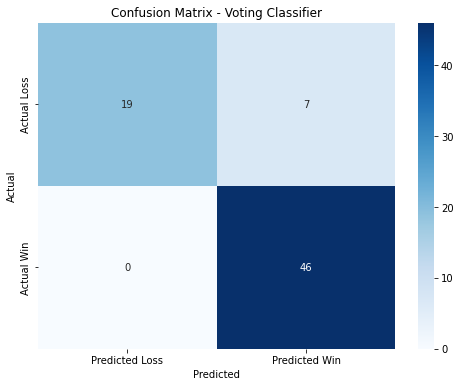

Accuracy: 0.9028
Precision: 0.8679
Recall: 1.0000
F1 Score: 0.9293


In [442]:
# Create confusion matrix for the voting classifier
#voting_clf = voting_clf.fit(x_train[features], y_train)
voting_clf=stacking_clf.fit(modeling_df[features], modeling_df['Win'])
voting_preds = voting_clf.predict(x_test[features])
conf_matrix = metrics.confusion_matrix(y_test, voting_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Loss', 'Predicted Win'],
            yticklabels=['Actual Loss', 'Actual Win'])
plt.title('Confusion Matrix - Voting Classifier')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Calculate and display classification metrics
print(f"Accuracy: {metrics.accuracy_score(y_test, voting_preds):.4f}")
print(f"Precision: {metrics.precision_score(y_test, voting_preds):.4f}")
print(f"Recall: {metrics.recall_score(y_test, voting_preds):.4f}")
print(f"F1 Score: {metrics.f1_score(y_test, voting_preds):.4f}")


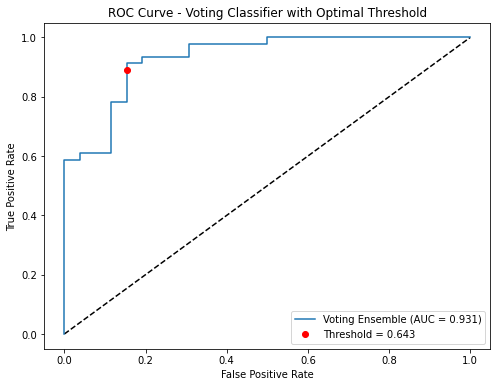

In [443]:
# Find optimal threshold for voting classifier
fpr, tpr, thresholds = metrics.roc_curve(y_test, voting_probs)
optimal_idx = np.argmax(tpr-fpr)
voting_thresh = thresholds[optimal_idx]

# Get TPR and FPR at optimal threshold
voting_preds = voting_probs > voting_thresh
voting_tpr = metrics.recall_score(y_test, voting_preds)
voting_fpr = 1 - metrics.recall_score(y_test, voting_preds, pos_label=0)

# Plot ROC curve with threshold point
plt.figure(figsize=(8,6))
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr_voting, tpr_voting, label=f'Voting Ensemble (AUC = {auc_voting:.3f})')
plt.plot(voting_fpr, voting_tpr, 'ro', label=f'Threshold = {voting_thresh:.3f}')
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Voting Classifier with Optimal Threshold')
plt.legend()
plt.show()


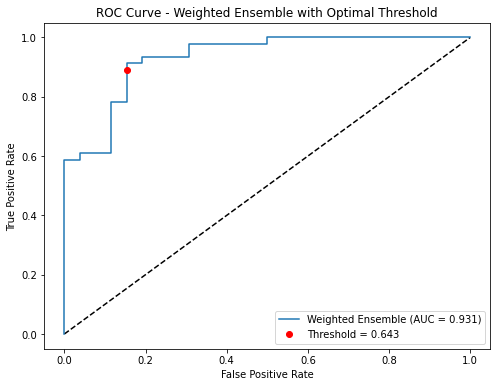

In [444]:
# Find optimal threshold for voting classifier
fpr, tpr, thresholds = metrics.roc_curve(y_test, weighted_probs)
optimal_idx = np.argmax(tpr-fpr)
weighted_thresh = thresholds[optimal_idx]

# Get TPR and FPR at optimal threshold
weighted_preds = weighted_probs > weighted_thresh
weighted_tpr = metrics.recall_score(y_test, weighted_preds)
weighted_fpr = 1 - metrics.recall_score(y_test, weighted_preds, pos_label=0)

# Plot ROC curve with threshold point
plt.figure(figsize=(8,6))
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr_weighted, tpr_weighted, label=f'Weighted Ensemble (AUC = {auc_weighted:.3f})')
plt.plot(weighted_fpr, weighted_tpr, 'ro', label=f'Threshold = {weighted_thresh:.3f}')
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Weighted Ensemble with Optimal Threshold')
plt.legend()
plt.show()


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


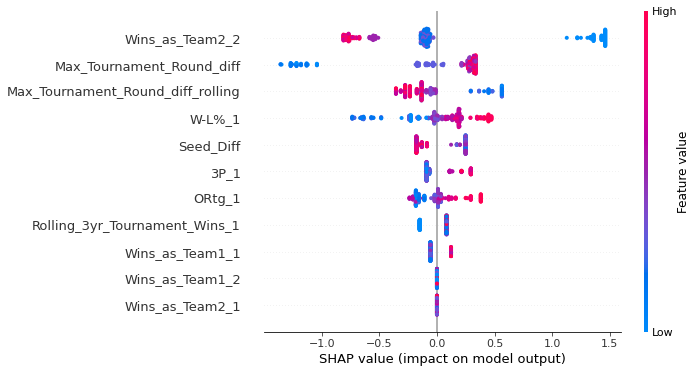

In [445]:
shapvalues = shap.TreeExplainer(XGB).shap_values(x_train[features])


shap.summary_plot(shapvalues, x_train[features])

In [446]:
# plot_importance(XGB, max_num_features=10)
# plt.show()

In [447]:
print(f'Accuracy : {metrics.accuracy_score(y_test, voting_clf.predict(x_test[features])):.1%}')
print(f'Precision : {metrics.precision_score(y_test, voting_clf.predict(x_test[features])):.1%}')
print(f'Recall : {metrics.recall_score(y_test, voting_clf.predict(x_test[features])):.1%}')

Accuracy : 90.3%
Precision : 86.8%
Recall : 100.0%


In [448]:
# Create a custom scoring function that mimics tournament scoring
def tournament_score(y_true, y_pred_proba, threshold):
    y_pred = y_pred_proba > threshold
    correct = y_true == y_pred
    upset_mask = modeling_df['is_upset'].values[y_test.index]
    round_weights = modeling_df['round_weight'].values[y_test.index]
    
    # Score correctly predicted games with round and upset weights
    scores = np.where(upset_mask, 2.0, 1.0) * correct * round_weights
    return np.sum(scores)

# Try different thresholds
thresholds = np.linspace(0.1, 0.9, 50)
scores = [tournament_score(y_test, voting_probs, t) for t in thresholds]
voting_thresh = thresholds[np.argmax(scores)]

print(f'Accuracy : {metrics.accuracy_score(y_test, voting_clf.predict_proba(x_test[features])[:,1]>voting_thresh):.1%}')
print(f'Precision : {metrics.precision_score(y_test, voting_clf.predict_proba(x_test[features])[:,1]>voting_thresh):.1%}')
print(f'Recall : {metrics.recall_score(y_test, voting_clf.predict_proba(x_test[features])[:,1]>voting_thresh):.1%}')

Accuracy : 87.5%
Precision : 87.8%
Recall : 93.5%


In [449]:
voting_thresh

0.6224489795918368

In [450]:
modeling_df = modeling_df.dropna()
if 'Prediction' in modeling_df.columns:
    modeling_df = modeling_df.drop(columns='Prediction')
modeling_df.insert(5, 'Prediction', voting_clf.predict_proba(modeling_df[features])[:,1]>voting_thresh)

modeling_df

,Season,Round,Team_1,Team_2,Win,Prediction,Team_1_Score,Team_2_Score,Team_1_Seed,Team_2_Seed,...,Max_Tournament_Round_diff,Max_Tournament_Round_diff_scaled,Max_Tournament_Round_1_rolling,Max_Tournament_Round_2_rolling,Max_Tournament_Round_diff_rolling,Max_Tournament_Round_diff_scaled_rolling,is_upset,round_weight,upset_weight,combined_weight
0,2018,1,Villanova,Radford,True,True,87,61,1,16,...,5.0,1.521050,6.0,0.0,6.0,1.962884,False,1.0,1.000000,1.0
1,2018,1,Virginia Tech,Alabama,False,False,83,86,8,9,...,-2.0,-1.651822,1.0,0.0,1.0,-0.175118,False,1.0,1.100000,1.0
2,2018,1,West Virginia,Murray State,True,True,85,68,5,12,...,3.0,0.614515,3.0,0.0,3.0,0.680083,False,1.0,1.000000,1.0
3,2018,1,Wichita State,Marshall,False,True,75,81,4,13,...,3.0,0.614515,3.0,0.0,3.0,0.680083,True,1.0,3.700000,1.0
4,2018,1,Florida,Bonaventure,True,True,77,62,6,11,...,4.0,1.067783,4.0,0.0,4.0,1.107684,False,1.0,1.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,2024,3,Marquette,NC State,False,False,58,67,2,11,...,-1.0,-1.198554,2.0,1.0,1.0,-0.175118,True,2.0,3.700000,2.0
353,2024,4,Duke,NC State,False,False,64,76,4,11,...,1.0,-0.292019,5.0,1.0,4.0,1.107684,True,3.0,2.852026,3.0
354,2024,5,UConn,Alabama,True,True,86,72,1,4,...,1.0,-0.292019,5.0,3.0,2.0,0.252483,False,4.0,1.000000,4.0
355,2024,5,Purdue,NC State,True,True,63,50,1,11,...,1.0,-0.292019,3.0,1.0,2.0,0.252483,False,4.0,1.000000,4.0


In [451]:
upsets = modeling_df.loc[((modeling_df['Win']==False) & (modeling_df['Team_1_Seed']<modeling_df['Team_2_Seed']-2)) | ((modeling_df['Win']==True) & (modeling_df['Team_1_Seed']-2>modeling_df['Team_2_Seed'])), :].iloc[:,:6]
(upsets['Prediction']==upsets['Win']).sum()/len(upsets)

0.6296296296296297

In [452]:
# Calculate overall accuracy
print(f"Overall Prediction Accuracy: {(modeling_df['Prediction']==modeling_df['Win']).mean():.1%}")

# Break down accuracy by season
accuracy_by_season = modeling_df.groupby('Season').apply(lambda x: (x['Prediction']==x['Win']).mean())
print("\nPrediction Accuracy by Season:")
print(accuracy_by_season)

# Calculate accuracy for predicting upsets
upset_predictions = modeling_df.loc[((modeling_df['Win']==False) & (modeling_df['Team_1_Seed']<modeling_df['Team_2_Seed']-2)) | 
                                  ((modeling_df['Win']==True) & (modeling_df['Team_1_Seed']-2>modeling_df['Team_2_Seed'])), :]

print(f"\nOverall Upset Prediction Accuracy: {(upset_predictions['Prediction']==upset_predictions['Win']).mean():.1%}")

# Break down by season
upset_accuracy_by_season = upset_predictions.groupby('Season').apply(lambda x: (x['Prediction']==x['Win']).mean())
print("\nUpset Prediction Accuracy by Season:")
print(upset_accuracy_by_season)


Overall Prediction Accuracy: 82.6%

Prediction Accuracy by Season:
Season
2018    0.809524
2019    0.966667
2021    0.852459
2022    0.842105
2023    0.678571
2024    0.800000
dtype: float64

Overall Upset Prediction Accuracy: 63.0%

Upset Prediction Accuracy by Season:
Season
2018    0.642857
2019    0.777778
2021    0.764706
2022    0.642857
2023    0.384615
2024    0.571429
dtype: float64


In [453]:
# Calculate accuracy by round
accuracy_by_round = modeling_df.groupby('Round').apply(lambda x: (x['Prediction']==x['Win']).mean())
print("Prediction Accuracy by Round:")
print(accuracy_by_round)

# Calculate upset accuracy by round
upset_accuracy_by_round = upset_predictions.groupby('Round').apply(lambda x: (x['Prediction']==x['Win']).mean())
print("\nUpset Prediction Accuracy by Round:")
print(upset_accuracy_by_round)


Prediction Accuracy by Round:
Round
1    0.823204
2    0.833333
3    0.765957
4    0.954545
5    0.750000
6    1.000000
dtype: float64

Upset Prediction Accuracy by Round:
Round
1    0.487179
2    0.800000
3    0.687500
4    1.000000
5    0.000000
dtype: float64


In [454]:
upsets[upsets['Season']==2024]

,Season,Round,Team_1,Team_2,Win,Prediction
299,2024,1,Auburn,Yale,False,True
300,2024,1,BYU,Duquesne,False,False
312,2024,1,Saint,Grand Canyon,False,True
320,2024,2,Baylor,Clemson,False,False
322,2024,3,UNC,Alabama,False,True
323,2024,3,Arizona,Clemson,False,False
329,2024,1,South Carolina,Oregon,False,False
341,2024,1,Wisconsin,James Madison,False,True
343,2024,1,Texas Tech,NC State,False,False
344,2024,1,Kentucky,Oakland,False,True


In [455]:
modeling_df.loc[(modeling_df['Season']==2024)&(modeling_df['Round']==1)&(modeling_df['Win']==True), ['Team_1', 'Team_2', 'Team_1_Seed', 'Team_2_Seed', 'Prediction', 'Win']]

,Team_1,Team_2,Team_1_Seed,Team_2_Seed,Prediction,Win
297,UConn,Stetson,1,16,True,True
301,Illinois,Morehead State,3,14,True,True
302,Washington State,Drake,7,10,True,True
303,Iowa State,South Dakota State,2,15,True,True
310,UNC,Wagner,1,16,True,True
313,Alabama,College of Charleston,4,13,True,True
314,Clemson,New Mexico,6,11,True,True
315,Baylor,Colgate,3,14,True,True
316,Dayton,Nevada,7,10,True,True
317,Arizona,Long Beach State,2,15,True,True


In [456]:
# Calculate prediction accuracy by seed difference
modeling_df['Seed_Difference'] = modeling_df['Team_1_Seed'] - modeling_df['Team_2_Seed']
accuracy_by_seed_diff = modeling_df.groupby('Seed_Difference').apply(lambda x: (x['Prediction'] == x['Win']).mean())
seed_diff_counts = modeling_df['Seed_Difference'].value_counts().sort_index()
accuracy_seed_diff = pd.DataFrame({'Seed_Difference': seed_diff_counts.index, 'Count': seed_diff_counts.values, 'Accuracy': accuracy_by_seed_diff.values})
accuracy_seed_diff['Seed_Difference'] = accuracy_seed_diff['Seed_Difference'].abs()
accuracy_seed_diff=accuracy_seed_diff.set_index('Seed_Difference')

print("\nPrediction Accuracy by Seed Difference:")
print(accuracy_seed_diff)



Prediction Accuracy by Seed Difference:
                 Count  Accuracy
Seed_Difference                 
15                  22  0.909091
13                  22  0.909091
12                   1  1.000000
11                  25  0.920000
10                   4  1.000000
9                   30  0.766667
8                   45  0.866667
7                   34  0.764706
6                    3  0.666667
5                   37  0.891892
4                   20  0.800000
3                   48  0.687500
2                   10  0.900000
1                   53  0.811321
0                    3  1.000000


In [457]:
# Predict probabilities using the existing Logistic Regression model (LR)
modeling_df['LR_Prob'] = LR.predict_proba(modeling_df[features])[:, 1]

# Use threshold of 0.704 for predicting a win
modeling_df['LR_Prediction'] = modeling_df['LR_Prob'] > 0.704

# Calculate accuracy by seed difference for Logistic Regression predictions
accuracy_seed_diff_lr = modeling_df.groupby('Seed_Difference').apply(lambda x: (x['LR_Prediction'] == x['Win']).mean())
seed_diff_counts_lr = modeling_df['Seed_Difference'].value_counts().sort_index()
accuracy_seed_diff_lr = pd.DataFrame({'Seed_Difference': seed_diff_counts_lr.index, 'Count': seed_diff_counts_lr.values, 'Accuracy': accuracy_seed_diff_lr.values})
accuracy_seed_diff_lr['Seed_Difference'] = accuracy_seed_diff_lr['Seed_Difference'].abs()
accuracy_seed_diff_lr = accuracy_seed_diff_lr.set_index('Seed_Difference')

print("\nPrediction Accuracy by Seed Difference (Logistic Regression):")
print(accuracy_seed_diff_lr)




Prediction Accuracy by Seed Difference (Logistic Regression):
                 Count  Accuracy
Seed_Difference                 
15                  22  0.909091
13                  22  0.863636
12                   1  1.000000
11                  25  0.920000
10                   4  1.000000
9                   30  0.666667
8                   45  0.755556
7                   34  0.764706
6                    3  0.666667
5                   37  0.729730
4                   20  0.750000
3                   48  0.541667
2                   10  0.600000
1                   53  0.716981
0                    3  0.666667


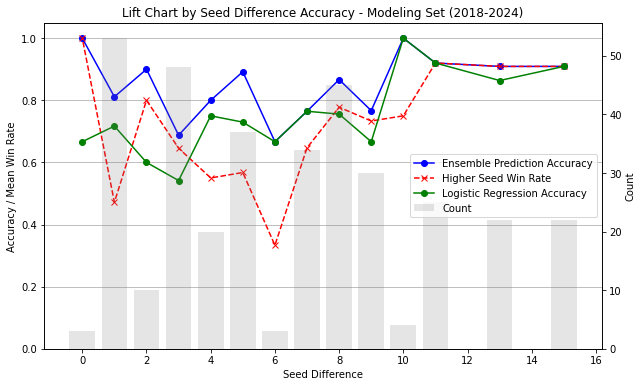

In [ ]:
# Calculate mean win rate by seed difference
mean_win_rate_by_seed_diff = modeling_df.groupby('Seed_Difference')['Win'].mean()
mean_win_rate_by_seed_diff.index = mean_win_rate_by_seed_diff.index.to_series().abs()

# Prepare data for lift chart
lift_data = accuracy_seed_diff.copy()
lift_data['Mean_Win_Rate'] = mean_win_rate_by_seed_diff

lift_data['Accuracy_lr'] = accuracy_seed_diff_lr['Accuracy']

lift_data=lift_data.drop(12)

# Create the lift chart
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot accuracy
ax1.plot(lift_data.index, lift_data['Accuracy'], marker='o', label='Ensemble Prediction Accuracy', color='blue')
ax1.plot(lift_data.index, lift_data['Mean_Win_Rate'], marker='x', label='Higher Seed Win Rate', color='red', linestyle='--')
ax1.plot(lift_data.index, lift_data['Accuracy_lr'], marker='o', label='Logistic Regression Accuracy', color='green')


ax2 = plt.gca().twinx()  # Create a second y-axis
ax2.bar(lift_data.index, lift_data['Count'], color='gray', alpha=0.2, label='Count')
ax2.set_ylabel('Count')


# Add labels and title
ax1.set_title('Lift Chart by Seed Difference Accuracy - Modeling Set (2018-2024)')
ax1.set_xlabel('Seed Difference')
ax1.set_ylabel('Accuracy / Mean Win Rate')
ax1.set_ylim(0,1.05)

fig.legend(loc='center right', bbox_to_anchor=(1, .5), bbox_transform=ax1.transAxes)  # Create a single legend


ax1.yaxis.grid(True)  # Add horizontal gridlines

plt.show()


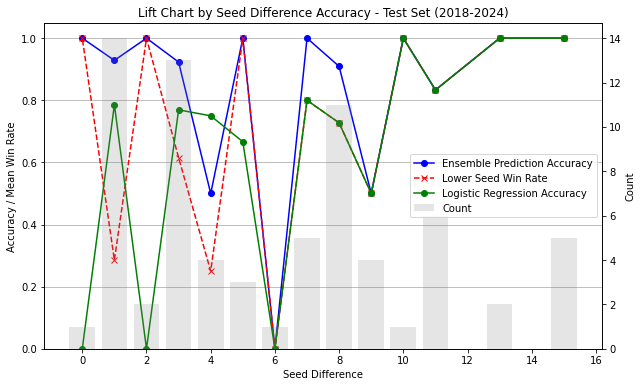

In [464]:
test_set = modeling_df.loc[x_test.index,:].copy()

# Calculate mean win rate by seed difference
mean_win_rate_by_seed_diff = test_set.groupby('Seed_Difference')['Win'].mean()
mean_win_rate_by_seed_diff.index = mean_win_rate_by_seed_diff.index.to_series().abs()

accuracy_seed_diff_lr = test_set.groupby('Seed_Difference').apply(lambda x: (x['LR_Prediction'] == x['Win']).mean())
seed_diff_counts_lr = test_set['Seed_Difference'].value_counts().sort_index()
accuracy_seed_diff_lr = pd.DataFrame({'Seed_Difference': seed_diff_counts_lr.index, 'Count': seed_diff_counts_lr.values, 'Accuracy': accuracy_seed_diff_lr.values})
accuracy_seed_diff_lr['Seed_Difference'] = accuracy_seed_diff_lr['Seed_Difference'].abs()
accuracy_seed_diff_lr = accuracy_seed_diff_lr.set_index('Seed_Difference')

accuracy_by_seed_diff = test_set.groupby('Seed_Difference').apply(lambda x: (x['Prediction'] == x['Win']).mean())
seed_diff_counts = test_set['Seed_Difference'].value_counts().sort_index()
accuracy_seed_diff = pd.DataFrame({'Seed_Difference': seed_diff_counts.index, 'Count': seed_diff_counts.values, 'Accuracy': accuracy_by_seed_diff.values})
accuracy_seed_diff['Seed_Difference'] = accuracy_seed_diff['Seed_Difference'].abs()
accuracy_seed_diff=accuracy_seed_diff.set_index('Seed_Difference')

# Prepare data for lift chart
lift_data = accuracy_seed_diff.copy()
lift_data['Mean_Win_Rate'] = mean_win_rate_by_seed_diff

lift_data['Accuracy_lr'] = accuracy_seed_diff_lr['Accuracy']

# Create the lift chart
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot accuracy
ax1.plot(lift_data.index, lift_data['Accuracy'], marker='o', label='Ensemble Prediction Accuracy', color='blue')
ax1.plot(lift_data.index, lift_data['Mean_Win_Rate'], marker='x', label='Lower Seed Win Rate', color='red', linestyle='--')
ax1.plot(lift_data.index, lift_data['Accuracy_lr'], marker='o', label='Logistic Regression Accuracy', color='green')


ax2 = plt.gca().twinx()  # Create a second y-axis
ax2.bar(lift_data.index, lift_data['Count'], color='gray', alpha=0.2, label='Count')
ax2.set_ylabel('Count')


# Add labels and title
ax1.set_title('Lift Chart by Seed Difference Accuracy - Test Set (2018-2024)')
ax1.set_xlabel('Seed Difference')
ax1.set_ylabel('Accuracy / Mean Win Rate')
ax1.set_ylim(0,1.05)

fig.legend(loc='center right', bbox_to_anchor=(1, .5), bbox_transform=ax1.transAxes)  # Create a single legend


ax1.yaxis.grid(True)  # Add horizontal gridlines

plt.show()


In [460]:
# Assuming holdout_df is already defined and preprocessed
# Ensure the same features are used
holdout_features = holdout_df[features]

# Predict probabilities on the holdout set
voting_clf=stacking_clf.fit(modeling_df[features], modeling_df['Win'])
holdout_probs = voting_clf.predict_proba(holdout_features)[:, 1]

# Get predictions based on a threshold (you can use the optimal threshold found earlier)
holdout_preds = holdout_probs > voting_thresh

# Calculate overall accuracy
overall_accuracy = np.mean(holdout_preds == holdout_df['Win'])
print(f"Overall Accuracy: {overall_accuracy:.3f}")

# Calculate accuracy by year
years = holdout_df['Season'].unique()
for year in years:
    year_mask = holdout_df['Season'] == year
    year_accuracy = np.mean(holdout_preds[year_mask] == holdout_df['Win'][year_mask])
    print(f"Accuracy for {year}: {year_accuracy:.3f}")

# Calculate upset accuracy
upset_mask = holdout_df['is_upset']
upset_accuracy = np.mean(holdout_preds[upset_mask] == holdout_df['Win'][upset_mask])
print(f"\nUpset Accuracy: {upset_accuracy:.3f}")


# Calculate upset accuracy by year
upset_accuracy_by_year = holdout_df.groupby('Season').apply(lambda x: np.mean(holdout_preds[x.index][x['is_upset']] == x['Win'][x['is_upset']]))
print("Upset Prediction Accuracy by Year:")
for year, accuracy in upset_accuracy_by_year.items():
    print(f"Upset Accuracy for {year}: {accuracy:.3f}")




Overall Accuracy: 0.722
Accuracy for 2010: 0.724
Accuracy for 2012: 0.690
Accuracy for 2013: 0.778
Accuracy for 2014: 0.764
Accuracy for 2015: 0.733
Accuracy for 2016: 0.650
Accuracy for 2017: 0.726

Upset Accuracy: 0.659
Upset Prediction Accuracy by Year:
Upset Accuracy for 2010: 0.600
Upset Accuracy for 2012: 0.545
Upset Accuracy for 2013: 0.667
Upset Accuracy for 2014: 0.667
Upset Accuracy for 2015: 0.700
Upset Accuracy for 2016: 0.615
Upset Accuracy for 2017: 0.833


In [461]:
# Calculate prediction accuracy by seed difference
holdout_df['Seed_Difference'] = holdout_df['Team_1_Seed'] - holdout_df['Team_2_Seed']
holdout_df['Prediction'] = holdout_preds
accuracy_by_seed_diff = holdout_df.groupby('Seed_Difference').apply(lambda x: (x['Prediction'] == x['Win']).mean())
seed_diff_counts = holdout_df['Seed_Difference'].value_counts().sort_index()
accuracy_seed_diff = pd.DataFrame({'Seed_Difference': seed_diff_counts.index, 'Count': seed_diff_counts.values, 'Accuracy': accuracy_by_seed_diff.values})
accuracy_seed_diff['Seed_Difference'] = accuracy_seed_diff['Seed_Difference'].abs()
accuracy_seed_diff = accuracy_seed_diff.set_index('Seed_Difference')

print("\nPrediction Accuracy by Seed Difference:")
print(accuracy_seed_diff)



Prediction Accuracy by Seed Difference:
                 Count  Accuracy
Seed_Difference                 
15                  21  1.000000
13                  26  0.884615
12                   2  1.000000
11                  28  0.821429
10                   2  1.000000
9                   32  0.812500
8                   47  0.638298
7                   47  0.659574
6                    5  0.800000
5                   43  0.674419
4                   23  0.608696
3                   57  0.754386
2                    5  0.600000
1                   62  0.612903
0                    7  0.714286


In [462]:
# Predict probabilities using the existing Logistic Regression model (LR)
holdout_df['LR_Prob'] = LR.predict_proba(holdout_df[features])[:, 1]

# Use threshold of 0.704 for predicting a win
holdout_df['LR_Prediction'] = holdout_df['LR_Prob'] > 0.704

# Calculate accuracy by seed difference for Logistic Regression predictions
accuracy_seed_diff_lr = holdout_df.groupby('Seed_Difference').apply(lambda x: (x['LR_Prediction'] == x['Win']).mean())
seed_diff_counts_lr = holdout_df['Seed_Difference'].value_counts().sort_index()
accuracy_seed_diff_lr = pd.DataFrame({'Seed_Difference': seed_diff_counts_lr.index, 'Count': seed_diff_counts_lr.values, 'Accuracy': accuracy_seed_diff_lr.values})
accuracy_seed_diff_lr['Seed_Difference'] = accuracy_seed_diff_lr['Seed_Difference'].abs()
accuracy_seed_diff_lr = accuracy_seed_diff_lr.set_index('Seed_Difference')

print("\nPrediction Accuracy by Seed Difference (Logistic Regression):")
print(accuracy_seed_diff_lr)


Prediction Accuracy by Seed Difference (Logistic Regression):
                 Count  Accuracy
Seed_Difference                 
15                  21  1.000000
13                  26  0.884615
12                   2  1.000000
11                  28  0.821429
10                   2  1.000000
9                   32  0.781250
8                   47  0.595745
7                   47  0.723404
6                    5  0.400000
5                   43  0.627907
4                   23  0.565217
3                   57  0.666667
2                    5  0.800000
1                   62  0.516129
0                    7  0.714286


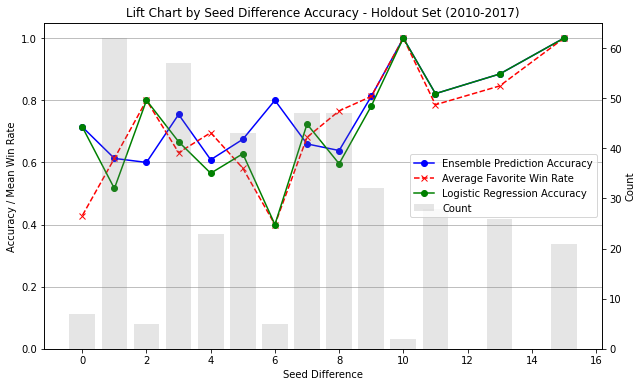

In [463]:
# Calculate mean win rate by seed difference
mean_win_rate_by_seed_diff = holdout_df.groupby('Seed_Difference')['Win'].mean()
mean_win_rate_by_seed_diff.index = mean_win_rate_by_seed_diff.index.to_series().abs()

# Prepare data for lift chart
lift_data = accuracy_seed_diff.copy()
lift_data['Mean_Win_Rate'] = mean_win_rate_by_seed_diff

lift_data['Accuracy_lr'] = accuracy_seed_diff_lr['Accuracy']

# Create the lift chart
fig, ax1 = plt.subplots(figsize=(10, 6))

lift_data=lift_data.drop(12)

# Plot accuracy
ax1.plot(lift_data.index, lift_data['Accuracy'], marker='o', label='Ensemble Prediction Accuracy', color='blue')
ax1.plot(lift_data.index, lift_data['Mean_Win_Rate'], marker='x', label='Average Favorite Win Rate', color='red', linestyle='--')
ax1.plot(lift_data.index, lift_data['Accuracy_lr'], marker='o', label='Logistic Regression Accuracy', color='green')

ax2 = plt.gca().twinx()  # Create a second y-axis
ax2.bar(lift_data.index, lift_data['Count'], color='gray', alpha=0.2, label='Count')
ax2.set_ylabel('Count')


# Add labels and title
ax1.set_title('Lift Chart by Seed Difference Accuracy - Holdout Set (2010-2017)')
ax1.set_xlabel('Seed Difference')
ax1.set_ylabel('Accuracy / Mean Win Rate')
ax1.set_ylim(0,1.05)

fig.legend(loc='center right', bbox_to_anchor=(1, .5), bbox_transform=ax1.transAxes)  # Create a single legend


ax1.yaxis.grid(True)  # Add horizontal gridlines

plt.show()


## 2022 Tournament

In [18]:
import bs4
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import time

In [19]:
url = 'https://www.sports-reference.com/cbb/postseason/2022-ncaa.html'

data_dict={
    'Season':[],
    'Round':[],
    'Team_1':[],
    'Team_2':[],
    'Team_1_Seed':[],
    'Team_2_Seed':[],
}
region_list = ['east', 'west', 'midwest', 'south']
year_list = ['2022']
for year in year_list:
    url = f'https://www.sports-reference.com/cbb/postseason/{year}-ncaa.html'
    options = Options()
    options.add_argument('--headless')
    options.add_argument('--disable-gpu')
    driver = webdriver.Chrome('C:\Program Files\ChromeDriver\chromedriver.exe',options=options)
    driver.get(url)
    time.sleep(2)
    page = driver.page_source
    soup = bs4.BeautifulSoup(page, 'html.parser')
    driver.quit()
    for region in region_list:
        games = soup.find('div', {'id':'brackets'}).find('div', {'id':region}).find_all('div', {'class':'round'})[0].find_all('div')
        for i in range(0, len(games), 3):
            data = games[i].get_text().replace('\n', ' ').split(' at ')[0].split()
            if 'Play-In' in data:
                data_dict['Season'].append(year)
                data_dict['Round'].append(1)
                team1 = ' '.join([x for x in data[:3] if x.isalpha()])
                num_list = [x for x in data if x.isnumeric()]
                team_1_seed = int(num_list[0])
                data_dict['Team_1'].append(team1)
                data_dict['Team_2'].append(region+'_Play-In')

                data_dict['Team_1_Seed'].append(team_1_seed)
                data_dict['Team_2_Seed'].append(17-team_1_seed)
            else:
                data_dict['Season'].append(year)
                data_dict['Round'].append(1)
                team1 = ' '.join([x for x in data[:3] if x.isalpha()])
                team2 = ' '.join([x for x in data[3:] if x.isalpha()])
                num_list = [x for x in data if x.isnumeric()]
                team_1_seed = int(num_list[0])
                team_2_seed = int(num_list[1])
                if team_2_seed < team_1_seed:
                    temp = team1
                    temp_seed = team_1_seed
                    temp_score = team_1_score
                    team1 = team2
                    team_1_seed = team_2_seed
                    team_1_score = team_2_score
                    team2 = temp
                    team_2_seed = temp_seed
                    team_2_score = temp_score

                data_dict['Team_1'].append(team1)
                data_dict['Team_2'].append(team2)

                data_dict['Team_1_Seed'].append(team_1_seed)
                data_dict['Team_2_Seed'].append(team_2_seed)

tourney_22 = pd.DataFrame.from_dict(data_dict)

In [20]:
tourney_22 = tourney_22.replace({
    'east_Play-In':'Indiana',
    'west_Play-In':'Notre Dame',
    'south_Play-In':'Wright State',
    'midwest_Play-In':'Texas Southern',
    'State Creighton':'Creighton',
})
tourney_22.loc[tourney_22['Team_1']=='Kentucky', 'Team_2']='Saint Peter\'s'

tourney_22

,Season,Round,Team_1,Team_2,Team_1_Seed,Team_2_Seed
0,2022,1,Baylor,Norfolk State,1,16
1,2022,1,UNC,Marquette,8,9
2,2022,1,Saint,Indiana,5,12
3,2022,1,UCLA,Akron,4,13
4,2022,1,Texas,Virginia Tech,6,11
5,2022,1,Purdue,Yale,3,14
6,2022,1,Murray State,San Francisco,7,10
7,2022,1,Kentucky,Saint Peter's,2,15
8,2022,1,Gonzaga,Georgia State,1,16
9,2022,1,Boise State,Memphis,8,9


In [21]:
teams_list = list(tourney_22['Team_1'].append(tourney_22['Team_2']))

In [22]:
basic = pd.read_html(f'https://www.sports-reference.com/cbb/seasons/2022-school-stats.html')[0]
subset = basic['Conf.']
subset = subset.replace({'W':0,'L':0, 'Conf.':0})
subset = subset.astype('float')
conf_pct = subset['W']/(subset['W']+subset['L'])
basic = basic.droplevel(0, axis=1)
col_list = list(basic.columns[1:8]) + list(basic.columns[-20:-18]) + list(basic.columns[-17:])
basic = basic[col_list]
basic = basic.loc[:,~basic.columns.duplicated()]
basic = basic.dropna()
basic.insert(5,'Conf. Pct', conf_pct)

advanced = pd.read_html(f'https://www.sports-reference.com/cbb/seasons/2022-advanced-school-stats.html')[0]
subset = advanced['School Advanced']
subset.insert(0,'School', advanced.droplevel(0, axis=1)['School'])
basic = basic.loc[basic['School']!='School',:]
basic.iloc[:,1:] = basic.iloc[:,1:].astype('float')
for column in basic.columns[4:]:
    if basic[column].mean()>1 and '%' not in column:
        basic[column] = basic[column]/basic['G']

final = basic.merge(subset, on='School')
final = final.loc[final['School']!='School',:]
final.iloc[:,1:] = final.iloc[:,1:].astype('float')

final.insert(0,'Season', '2022')
final['School']=final['School'].str.strip().str.replace('NCAA', '').str.strip()
school_replace_dict = {
    'Southern Methodist':'SMU',
    'North Carolina':'UNC',
    'Miami (FL)':'Miami',
    'Saint Mary\'s (CA)':'Saint',
    'Maryland-Baltimore County':'UMBC',
    'Loyola (IL)':'Loyola',
    'Virginia Commonwealth':'VCU',
    'Louisiana State': 'LSU',
    'Mississippi':'Ole Miss',
    'Brigham Young':'BYU',
    'Connecticut': 'UConn',
    'Southern California' :'USC',
    'East Tennessee State':'ETSU',
    'Mount St. Mary\'s':'Mount',
    'St. Bonaventure':'Bonaventure',
    'Stephen F. Austin':'Stephen Austin',
    'Pennsylvania':'Penn',
    'Central Florida':'UCF',
    'UC Santa Barbara':'UCSB'  
}

final['School']=final['School'].replace(school_replace_dict)
final = final[final['School'].isin(teams_list)]
final[final.columns[2:]] = StandardScaler().fit_transform(final[final.columns[2:]])

final


,Season,School,G,W,L,W-L%,Conf. Pct,SRS,SOS,Tm.,...,3PAr,TS%,TRB%,AST%,STL%,BLK%,eFG%,TOV%,ORB%,FT/FGA
2,2022,Akron,0.368401,0.064818,0.121195,-0.061603,-0.112898,-1.415051,-1.449693,-0.746426,...,1.080574,0.380076,0.167753,-0.787028,-0.332906,-0.458880,0.373821,0.119868,0.015964,1.647215
4,2022,UAB,1.005635,0.953745,-0.553283,0.654257,0.453004,-0.078125,-0.814141,1.360324,...,-0.918972,0.140028,0.214030,-1.739601,1.915206,0.390482,0.194207,-0.883338,0.776315,-0.651009
6,2022,Alabama,-0.268833,-1.416727,1.470153,-1.482637,-1.568074,0.483846,1.332120,1.203289,...,2.482554,-0.260052,-0.109907,0.048904,-0.128532,0.390482,-0.380556,0.887027,1.180251,0.609307
12,2022,Arizona,1.005635,2.138981,-1.902241,1.915023,1.342278,1.578277,0.492648,2.221771,...,-0.344390,1.340268,1.139566,2.478940,-0.281812,0.880499,1.200043,0.178881,0.918880,1.128261
16,2022,Arkansas,0.368401,0.361127,-0.216044,0.269616,0.048788,0.614716,0.682974,0.531111,...,-0.666156,-0.740148,-0.109907,0.048904,0.433496,0.390482,-1.206779,-0.116180,0.039725,2.129101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,2022,Villanova,0.368401,0.657436,-0.553283,0.590150,0.614690,0.993212,0.990553,-0.423680,...,2.022889,0.300060,-0.387568,-0.709266,-0.026345,-1.177572,-0.200943,-1.060375,0.063486,0.831716
336,2022,Virginia Tech,1.642869,-0.231491,1.132913,-0.809515,-1.204280,0.320900,0.283630,-0.843826,...,0.988641,0.740148,-0.572675,0.534911,-0.690560,-0.393545,0.948584,-0.175192,-0.601820,-1.948394
351,2022,Wisconsin,-0.906067,0.064818,-0.553283,0.440567,0.250896,0.277277,0.954867,-0.851188,...,-0.252457,-1.420284,-1.174274,-1.622960,-0.946027,-1.046901,-1.566006,-2.358643,-1.124561,0.423967
353,2022,Wright State,1.642869,-0.527800,1.470153,-1.108680,-0.245187,-1.751207,-1.663809,0.316331,...,-1.056872,0.020004,-0.665229,-0.281580,-0.741654,-1.014233,-0.236865,0.119868,0.182291,0.646376


In [23]:
df_22 = tourney_22.merge(final, left_on=['Season', 'Team_1'], right_on=['Season', 'School'], how='left')
df_22 = df_22.drop(columns='School').rename(columns={col : col+'_1' for col in df_22.columns[6:]})
df_22 = df_22.merge(final, left_on=['Season', 'Team_2'], right_on=['Season', 'School'], how='left')
df_22 = df_22.drop(columns='School').rename(columns={col : col+'_2' for col in df_22.columns[46:]})
df_22

,Season,Round,Team_1,Team_2,Team_1_Seed,Team_2_Seed,G_1,W_1,L_1,W-L%_1,...,3PAr_2,TS%_2,TRB%_2,AST%_2,STL%_2,BLK%_2,eFG%_2,TOV%_2,ORB%_2,FT/FGA_2
0,2022,1,Baylor,Norfolk State,1,16,-0.268833,0.657436,-0.890523,0.857261,...,-0.390357,0.100020,0.445414,-0.981430,-0.179625,0.227143,0.086439,1.182088,-0.031558,1.276534
1,2022,1,UNC,Marquette,8,9,0.368401,0.064818,0.121195,-0.061603,...,1.034607,-0.060012,-2.608855,1.312523,0.586776,0.651825,0.014594,0.296905,-1.956194,-1.058759
2,2022,1,Saint,Indiana,5,12,-0.268833,0.361127,-0.553283,0.515359,...,-1.309688,-0.620124,-0.295015,0.807075,-0.792747,1.207177,-0.560170,0.001844,-0.791908,0.164490
3,2022,1,UCLA,Akron,4,13,-0.268833,0.361127,-0.553283,0.515359,...,1.080574,0.380076,0.167753,-0.787028,-0.332906,-0.458880,0.373821,0.119868,0.015964,1.647215
4,2022,1,Texas,Virginia Tech,6,11,-0.268833,-0.824109,0.795674,-0.820200,...,0.988641,0.740148,-0.572675,0.534911,-0.690560,-0.393545,0.948584,-0.175192,-0.601820,-1.948394
5,2022,1,Purdue,Yale,3,14,1.005635,0.953745,-0.553283,0.654257,...,-0.206490,-0.620124,-1.081720,-1.253594,-0.486186,-0.458880,-0.775706,0.532954,-1.172083,0.461035
6,2022,1,Murray State,San Francisco,7,10,-0.268833,1.842672,-2.239480,2.192820,...,1.793056,0.140028,0.445414,-1.000871,0.586776,0.259811,0.409743,0.355917,-0.055318,-1.021690
7,2022,1,Kentucky,Saint Peter's,2,15,0.368401,0.657436,-0.553283,0.590150,...,-1.562505,-1.460292,-0.248738,-0.164939,0.535683,1.305181,-1.494160,1.477148,0.324857,0.942921
8,2022,1,Gonzaga,Georgia State,1,16,-2.180535,0.657436,-1.902241,1.754756,...,0.115276,-2.260452,-0.804059,0.301628,1.608646,0.749828,-2.176692,-0.470253,0.871358,-0.688077
9,2022,1,Boise State,Memphis,8,9,1.005635,0.953745,-0.553283,0.654257,...,-1.470571,0.020004,0.723075,1.351403,1.250991,1.991204,0.014594,2.539368,1.631709,1.387738


In [24]:
df_22.insert(6, 'Proba', XGB.predict_proba(df_22[features])[:,1])
df_22.insert(6, 'Pred', XGB.predict_proba(df_22[features])[:,1]>thresh)
df_22

,Season,Round,Team_1,Team_2,Team_1_Seed,Team_2_Seed,Pred,Proba,G_1,W_1,...,3PAr_2,TS%_2,TRB%_2,AST%_2,STL%_2,BLK%_2,eFG%_2,TOV%_2,ORB%_2,FT/FGA_2
0,2022,1,Baylor,Norfolk State,1,16,True,0.923630,-0.268833,0.657436,...,-0.390357,0.100020,0.445414,-0.981430,-0.179625,0.227143,0.086439,1.182088,-0.031558,1.276534
1,2022,1,UNC,Marquette,8,9,False,0.398755,0.368401,0.064818,...,1.034607,-0.060012,-2.608855,1.312523,0.586776,0.651825,0.014594,0.296905,-1.956194,-1.058759
2,2022,1,Saint,Indiana,5,12,False,0.395106,-0.268833,0.361127,...,-1.309688,-0.620124,-0.295015,0.807075,-0.792747,1.207177,-0.560170,0.001844,-0.791908,0.164490
3,2022,1,UCLA,Akron,4,13,True,0.941515,-0.268833,0.361127,...,1.080574,0.380076,0.167753,-0.787028,-0.332906,-0.458880,0.373821,0.119868,0.015964,1.647215
4,2022,1,Texas,Virginia Tech,6,11,False,0.543890,-0.268833,-0.824109,...,0.988641,0.740148,-0.572675,0.534911,-0.690560,-0.393545,0.948584,-0.175192,-0.601820,-1.948394
5,2022,1,Purdue,Yale,3,14,True,0.910493,1.005635,0.953745,...,-0.206490,-0.620124,-1.081720,-1.253594,-0.486186,-0.458880,-0.775706,0.532954,-1.172083,0.461035
6,2022,1,Murray State,San Francisco,7,10,False,0.747677,-0.268833,1.842672,...,1.793056,0.140028,0.445414,-1.000871,0.586776,0.259811,0.409743,0.355917,-0.055318,-1.021690
7,2022,1,Kentucky,Saint Peter's,2,15,True,0.956606,0.368401,0.657436,...,-1.562505,-1.460292,-0.248738,-0.164939,0.535683,1.305181,-1.494160,1.477148,0.324857,0.942921
8,2022,1,Gonzaga,Georgia State,1,16,True,0.954123,-2.180535,0.657436,...,0.115276,-2.260452,-0.804059,0.301628,1.608646,0.749828,-2.176692,-0.470253,0.871358,-0.688077
9,2022,1,Boise State,Memphis,8,9,False,0.359263,1.005635,0.953745,...,-1.470571,0.020004,0.723075,1.351403,1.250991,1.991204,0.014594,2.539368,1.631709,1.387738


In [25]:
temp1 = df_22[[x for x in df_22.columns if '_1' in x]]
temp1.columns = [x.strip('_1') for x in temp1.columns]
temp1 = temp1.drop(columns = 'Team_1_Seed')
temp2 = df_22[[x for x in df_22.columns if '_2' in x]]
temp2.columns = [x.strip('_2') for x in temp2.columns]
temp2 = temp2.drop(columns = 'Team_2_Seed')

stats = temp1.append(temp2)
stats['Season']='2022'
stats = stats.rename(columns={'Team':'School'})

In [26]:
next_round = pd.DataFrame(df_22.loc[df_22['Pred']==True,['Team_1', 'Team_1_Seed']].rename(columns={'Team_1':'Team', 'Team_1_Seed':'Seed'}).append(df_22.loc[df_22['Pred']==False,['Team_2', 'Team_2_Seed']].rename(columns={'Team_2':'Team', 'Team_2_Seed':'Seed'})))
next_round = next_round.sort_index()

df_list = []

for round in range(2,7):
    data_dict={
        'Season':[],
        'Round':[],
        'Team_1':[],
        'Team_2':[],
        'Team_1_Seed':[],
        'Team_2_Seed':[],
    }
    if round > 2:
        next_round = pd.DataFrame(next_round.loc[next_round['Pred']==True,['Team_1', 'Team_1_Seed']].rename(columns={'Team_1':'Team', 'Team_1_Seed':'Seed'}).append(next_round.loc[next_round['Pred']==False,['Team_2', 'Team_2_Seed']].rename(columns={'Team_2':'Team', 'Team_2_Seed':'Seed'})))
        next_round = next_round.sort_index()
    for i in range(0,len(next_round),2):
        data_dict['Season'].append('2022')
        data_dict['Round'].append(round)
        if next_round.iloc[i,1]<next_round.iloc[i+1,1]:
            team1 = next_round.iloc[i,0]
            team2 = next_round.iloc[i+1,0]
            team1_seed = next_round.iloc[i,1]
            team2_seed = next_round.iloc[i+1,1]
        else:
            team1 = next_round.iloc[i+1,0]
            team2 = next_round.iloc[i,0]
            team1_seed = next_round.iloc[i+1,1]
            team2_seed = next_round.iloc[i,1]
        data_dict['Team_1'].append(team1)
        data_dict['Team_2'].append(team2)
        data_dict['Team_1_Seed'].append(team1_seed)
        data_dict['Team_2_Seed'].append(team2_seed)

    next_round=pd.DataFrame.from_dict(data_dict)

    next_round = next_round.merge(stats, left_on=['Season', 'Team_1'], right_on=['Season', 'School'], how='left')
    next_round = next_round.drop(columns='School').rename(columns={col : col+'_1' for col in next_round.columns[6:]})
    next_round = next_round.merge(stats, left_on=['Season', 'Team_2'], right_on=['Season', 'School'], how='left')
    next_round = next_round.drop(columns='School').rename(columns={col : col+'_2' for col in next_round.columns[46:]})

    next_round.insert(6, 'Proba', XGB.predict_proba(next_round[features])[:,1])
    next_round.insert(6, 'Pred', XGB.predict_proba(next_round[features])[:,1]>thresh)

    df_list.append(next_round.copy())

final = pd.concat([df_22]+df_list)


In [27]:
final[final['Round']==1].sort_values(by='Pred')

,Season,Round,Team_1,Team_2,Team_1_Seed,Team_2_Seed,Pred,Proba,G_1,W_1,...,3PAr_2,TS%_2,TRB%_2,AST%_2,STL%_2,BLK%_2,eFG%_2,TOV%_2,ORB%_2,FT/FGA_2
25,2022,1,Seton Hall,TCU,8,9,False,0.285052,-0.906067,-0.824109,...,-1.217755,-1.580316,1.556058,0.243307,-0.230719,0.227143,-1.314547,1.713197,1.702991,-0.725145
21,2022,1,Wisconsin,Colgate,3,14,False,0.720554,-0.906067,0.064818,...,1.172507,0.980196,-0.341291,1.817970,-0.281812,-0.360877,1.307811,-0.293217,-1.005756,-1.614781
17,2022,1,San Diego,Creighton,8,9,False,0.376487,-0.906067,-2.601963,...,0.230192,-0.780156,-0.387568,-0.301021,-0.997121,-0.066867,-0.596093,1.654185,-0.483015,-1.466508
22,2022,1,USC,Miami,7,10,False,0.674701,0.368401,0.657436,...,-0.298424,0.580116,-2.701408,-0.339901,1.608646,-0.720223,0.589357,-1.414448,-1.718585,-0.539805
30,2022,1,Ohio State,Loyola,7,10,False,0.575967,-1.543301,-1.416727,...,1.287423,1.340268,-0.156184,0.865396,0.280216,-1.112236,1.415579,0.650978,-1.314648,-0.020851
14,2022,1,Michigan State,Davidson,7,10,False,0.507997,1.005635,-0.527800,...,0.919691,1.420284,-0.156184,0.457150,-1.405869,-0.818226,1.271889,-1.060375,-1.623541,0.498103
12,2022,1,Alabama,Notre Dame,6,11,False,0.678721,-0.268833,-1.416727,...,1.172507,0.620124,-1.127997,0.301628,-1.048214,-1.896264,0.661202,-0.824326,-1.932433,-1.021690
19,2022,1,Providence,South Dakota State,4,13,False,0.483754,-1.543301,0.361127,...,-0.436323,2.980596,0.121477,-0.728707,-0.690560,-1.275575,2.816565,-0.824326,-1.480975,1.054125
9,2022,1,Boise State,Memphis,8,9,False,0.359263,1.005635,0.953745,...,-1.470571,0.020004,0.723075,1.351403,1.250991,1.991204,0.014594,2.539368,1.631709,1.387738
20,2022,1,LSU,Iowa State,6,11,False,0.605418,0.368401,-0.527800,...,0.046326,-1.260252,-1.637042,1.448605,1.353178,-0.393545,-0.955320,1.595173,-0.578059,-1.318236


In [28]:
final.to_csv('ncaab_preds.csv', index=False)